<a href="https://colab.research.google.com/github/adeebiscoding/tenserflow/blob/main/06_transfer_learning_scaling_ip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Sep 25 15:10:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    35W / 250W |   4683MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## creating helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-25 15:10:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-25 15:10:49 (51.7 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [ ]:
from helper_functions import *

## 101 food classes: working with less data

our goal is to beat the original food 101 paper (50.76% accuray) with 10% of training data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2022-09-25 15:10:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.2’

ent.zip.2            52%[=========>          ] 811.79M   105MB/s    eta 6s     ^C


KeyboardInterrupt: ignored

In [ ]:
walk_through_dir("101_food_classes_10_percent")

In [ ]:
import tensorflow as tf

IMG_SIZE=(224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = "categorical",
                                                                                image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                                label_mode = "categorical",
                                                                                image_size = IMG_SIZE,
                                                                 shuffle = False) # dont shuffle test data for prediction analysis


## Train big dog model with transfer learning on 10% on 101 food classes

Steps we gonna take:
* Create ModelCheckpoint callback
* create augmentation layer
* build headless( no top layers) functional efficinetnetb0 back-bone model
* compile
* feature extract 5 full passes

In [ ]:
# create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                         save_weights_only=True,
                                                         monitor = "val_accuracy",
                                                         save_best_only = True)

In [ ]:
# Create data aug layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name = "data_augmentation")

In [ ]:
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape = input_shape, name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = "global_avg_pool_layer")(x)
outputs = layers.Dense(101, activation = "softmax", name = "output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs = 5,
                                           validation_data = test_data,
                                           validation_steps = int(0.15 * len(test_data)),
                                           callbacks = [checkpoint_callback])

In [ ]:
fine_tuning_results = model.evaluate(test_data)

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

## Finetuning

In [ ]:
# unfreeze all layers in base model

base_model.trainable = True

# keeping last 5 layers trainable
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [ ]:
fine_tune_epochs = 10 # we will train model for 10 epochs total
history_all_classes_10_percent_fine_tuned = model.fit(train_data_all_10_percent,
                                           epochs = fine_tune_epochs,
                                           initial_epoch = history_all_classes_10_percent.epoch[-1],
                                           validation_data = test_data,
                                           validation_steps = int(0.15 * len(test_data)),
                                           callbacks = [checkpoint_callback])

In [ ]:
all_clsses_10_percent_fine_tune_results = model.evaluate(test_data)
all_clsses_10_percent_fine_tune_results

In [ ]:
plot_loss_curves(history_all_classes_10_percent_fine_tuned)

In [ ]:
compare_historys(history_all_classes_10_percent,history_all_classes_10_percent_fine_tuned )

##Saving and loading model

In [ ]:
model.save("/content/drive/MyDrive/TFcourse/101_food_classes_10_percent_saved_big_dog_model")


In [ ]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/TFcourse/101_food_classes_10_percent_saved_big_dog_model")

##Evaluate performance of big dog model on differnet classes

In [ ]:
import tensorflow as tf
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
results_downloaded_model = model.evaluate(test_data)

##making predictions with trained model

In [ ]:
preds_probs = model.predict(test_data, verbose = 1)

In [ ]:
#790 is num of batches, 790 * 32 = 25k

In [ ]:
len(preds_probs)

In [ ]:
preds_probs.shape

In [ ]:
preds_probs[:1]

In [ ]:
#get pred classes for each label (max number in array)

pred_classes = preds_probs.argmax(axis = 1)
pred_classes[:10]

In [ ]:
# to get test labels we need to unravel our test_Data batchdataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently labels are one hot encoded

y_labels[:10]
# all labels are 0, because we set shuffle to false, so first images will be from the first label

##Evaluating models predictions

one way to check model's predictions array is in same order as test labels array is to use accuracy score

In [ ]:
#lets try sklearns accuracy score function

from sklearn.metrics import accuracy_score, confusion_matrix

sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)


sklearn_accuracy

In [ ]:
import seaborn as sns

sns.heatmap(confusion_matrix(y_true = y_labels,
                                  y_pred = pred_classes))

In [ ]:
##Lets make confusio nmatrix

make_confusion_matrix(y_true = y_labels,
                                  y_pred = pred_classes, classes = test_data.class_names)

In [ ]:
make_confusion_matrix(y_true = y_labels,
                                  y_pred = pred_classes, classes = test_data.class_names,
                      figsize = (100,100),text_size = 25)

In [ ]:
# remaking make confusion matrix so that x labels are vertical
import itertools
import matplotlib.pyplot as plt
import numpy as np
import sklearn
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  plt.xticks(rotation = 70, fontsize = text_size)
  
  plt.xticks( fontsize = text_size)
  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [ ]:
make_confusion_matrix(y_true = y_labels,
                                  y_pred = pred_classes, classes = test_data.class_names,
                      figsize = (100,100),text_size = 25)

##Classification report

In [ ]:
#from sklearn

print(sklearn.metrics.classification_report(y_true = y_labels,
                                  y_pred = pred_classes))

In [ ]:
classification_report_dict = sklearn.metrics.classification_report(y_true = y_labels,
                                  y_pred = pred_classes, output_dict = True)

In [ ]:
classification_report_dict

In [ ]:
#plot all classes f1 score

class_f1_scores = {}

for k, v in classification_report_dict.items():
  if  k == "accuracy": 
    break
  else:
    class_f1_scores[test_data.class_names[int(k)]] = v["f1-score"]

class_f1_scores

In [ ]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

In [ ]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

##Visualizing predictions on custom imagea

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [ ]:
import os
import random
class_names = test_data.class_names
plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/"+class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

##Finding most wrong prediction

We'll go through the following steps:

1. Get all of the image file paths in the test dataset using the list_files() method.

2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.

   * Note: We don't necessarily have to create a DataFrame like this but  it'll     help us visualize things as we go.

3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).

4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.

5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [ ]:
# get all image filepath

filepaths = []

for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle = False):
  filepaths.append(filepath.numpy()) #.numpy to change to strings from tensor format

In [ ]:
import pandas as pd

pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis =1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})

In [ ]:
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847418,apple_pie,gyoza
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658607,apple_pie,pulled_pork_sandwich
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367900,apple_pie,prime_rib
...,...,...,...,...,...,...
25245,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.972823,waffles,waffles
25246,b'/content/101_food_classes_10_percent/test/wa...,100,16,0.878027,waffles,cheese_plate
25247,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.537899,waffles,waffles
25248,b'/content/101_food_classes_10_percent/test/wa...,100,94,0.501951,waffles,strawberry_shortcake


In [ ]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]

In [ ]:
#sort to have most wronf prediciotns at top

top_100_wrong = pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf", ascending=False)[:100]

In [ ]:
top_100_wrong.head(20)

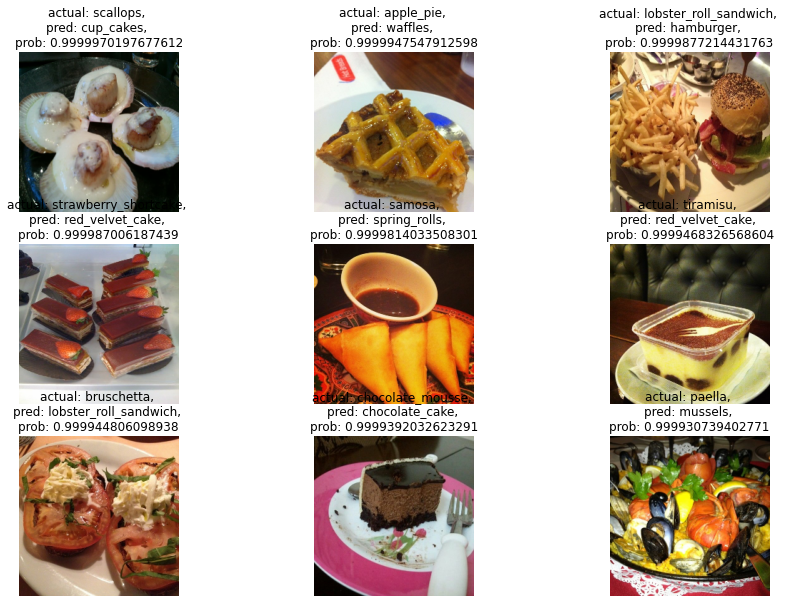

In [ ]:
images_to_view = 9
start_index = 0
plt.figure(figsize=(15,10))

for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img = load_and_prep_image(row[1], scale=False)
  _,_,_,_, pred_prob, y_true_classname, y_pred_classname,_ = row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, \npred: {y_pred_classname}, \nprob: {pred_prob}")
  plt.axis(False)

## Test model from custom images

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2022-09-25 15:26:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  28.3MB/s    in 0.4s    

2022-09-25 15:26:40 (28.3 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
custom_food_images = ["custom_food_images/"+img_path for img_path in os.listdir("custom_food_images") ]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg']

In [ ]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale = False)
  pred_prob = model.predict(tf.expand_dims(img, axis = 0))
  pred_class = class_names[pred_prob.argmax()]
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}\n prob: {pred_prob.max():.2f}")
  plt.axis(False)

In [ ]:
!wget https://qph.cf2.quoracdn.net/main-qimg-c59e2c92f29985ecf62cb0aee42ae48a-lq

--2022-09-25 15:32:38--  https://qph.cf2.quoracdn.net/main-qimg-c59e2c92f29985ecf62cb0aee42ae48a-lq
Resolving qph.cf2.quoracdn.net (qph.cf2.quoracdn.net)... 162.159.153.247, 162.159.152.17
Connecting to qph.cf2.quoracdn.net (qph.cf2.quoracdn.net)|162.159.153.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56889 (56K) [image/jpeg]
Saving to: ‘main-qimg-c59e2c92f29985ecf62cb0aee42ae48a-lq’

main-qimg-c59e2c92f 100%[===================>]  55.56K  --.-KB/s    in 0.001s  

2022-09-25 15:32:38 (58.2 MB/s) - ‘main-qimg-c59e2c92f29985ecf62cb0aee42ae48a-lq’ saved [56889/56889]



--2022-09-25 15:35:00--  https://www.indianhealthyrecipes.com/wp-content/uploads/2022/02/hyderabadi-biryani-recipe-chicken.jpg
Resolving www.indianhealthyrecipes.com (www.indianhealthyrecipes.com)... 23.199.34.107, 23.210.215.146, 2600:1417:e800::b81a:7f42, ...
Connecting to www.indianhealthyrecipes.com (www.indianhealthyrecipes.com)|23.199.34.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 227707 (222K) [image/jpeg]
Saving to: ‘hyderabadi-biryani-recipe-chicken.jpg.1’

hyderabadi-biryani- 100%[===================>] 222.37K  --.-KB/s    in 0.01s   

2022-09-25 15:35:00 (18.5 MB/s) - ‘hyderabadi-biryani-recipe-chicken.jpg.1’ saved [227707/227707]



(-0.5, 223.5, 223.5, -0.5)

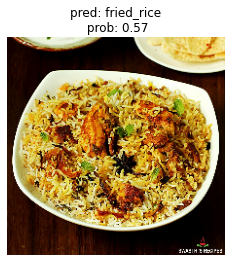

In [ ]:
  !wget https://www.indianhealthyrecipes.com/wp-content/uploads/2022/02/hyderabadi-biryani-recipe-chicken.jpg
  img = load_and_prep_image("/content/hyderabadi-biryani-recipe-chicken.jpg", scale = False)
  pred_prob = model.predict(tf.expand_dims(img, axis = 0))
  pred_class = class_names[pred_prob.argmax()]
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}\n prob: {pred_prob.max():.2f}")
  plt.axis(False)